# Redes Convolucionais com PyTorch


Source: https://github.com/pytorch/examples/tree/master/mnist

Dependências

In [2]:
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
with open('/usr/local/cuda/version.txt', 'r') as f:
    nums = f.read().split()[2].split('.')  # expected file content: "CUDA Version: 9.2.0"
    cuda_version = nums[0] + nums[1]  # expected output: "92"
!pip install http://download.pytorch.org/whl/cu{cuda_version}/torch-0.4.1-{platform}-linux_x86_64.whl
!pip install torchvision

    100% |████████████████████████████████| 512.6MB 45.5MB/s 
tcmalloc: large alloc 1073750016 bytes == 0x5793c000 @  0x7f4b585672a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070
    100% |████████████████████████████████| 61kB 4.8MB/s 
    100% |████████████████████████████████| 2.0MB 15.2MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [0]:
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Definição da rede

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [21]:
model = Net()
print(model)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


## Definição das rotinas de treinamento

In [0]:
def train(model, device, train_loader, optimizer, epoch, log_interval=10):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

## Execução do treinamento

In [53]:
# Training settings
batch_size = 64
test_batch_size = 1000
epochs = 10
lr = 0.01
momentum = 0.5
seed = 1
log_interval = 200

use_cuda = torch.cuda.is_available()

torch.manual_seed(seed)

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data/', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data/', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

t_start = datetime.now()

for epoch in range(1, epochs + 1):
    t_epoch_start = datetime.now()
    train(model, device, train_loader, optimizer, epoch, log_interval)
    test(model, device, test_loader)
    t_epoch_end = datetime.now()
    print('Epoch:', epoch, ', took:', t_epoch_end - t_epoch_start)

t_end = datetime.now()

print('Elapsed time:', t_end - t_start)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.193385
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.242595
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.260107
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.293260
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.146084

Test set: Average loss: 0.0491, Accuracy: 9841/10000 (98.41%)

Epoch: 1 , took: 0:00:14.209642
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.164558
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.070380
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.055728
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.145325
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.351477

Test set: Average loss: 0.0490, Accuracy: 9851/10000 (98.51%)

Epoch: 2 , took: 0:00:14.907634
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.162919
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.222875
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.522661
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.080713
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.059620

Test set: Average loss: 0.0445, Accuracy: 9855/10000 (98.55%)

Epoch: 3 

predição: 1


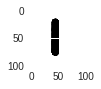

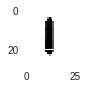

In [50]:
from google.colab import files
from skimage.io import imread, use_plugin
from skimage.transform import resize
import matplotlib.pyplot as plt
use_plugin('matplotlib')

uploaded = files.upload()
file_name = list(uploaded.keys())[0]

# lê imagem
img = imread(file_name)[:, :, 0]
plt.figure(figsize=(1,1))
plt.imshow(img, cmap='gray')

# resize para 28x28
resized = resize(img, (28, 28), mode='constant')
plt.figure(figsize=(1,1))
plt.imshow(resized, cmap='gray')

# inverte cores (fundo deve ser 0)
resized = 255 - resized

# converte para tensor CxHxW (canal, altura, largura)
x = torch.from_numpy(resized).float().unsqueeze(dim=0)

# aplica pré-processamento (mesmo usado durante treinamento)
x = transforms.Normalize((0.1307,), (0.3081,))(x)

# converte para tensor NxCxHxW (batch, canal, altura, largura) na GPU
x = x.unsqueeze(0).to(device)

model.eval()
output = model(x)
pred = output.max(dim=1)[1].item()

print('predição:', pred)

!rm {file_name}